Hello everyone! Today I conducted another analysis. More and more often in my learning journey, I find myself needing to delve deeper into understanding how "join" works, both its function in SQL and in Python. I'm specifically referring to Cartesian products, when rows multiply, and pointers go off into space (I still have gaps in this knowledge :( ). However, I've made an attempt to tackle this, which you can see in this notebook. So, what was the task? I found it online, it was from a telecommunications company. The company wasn't specified, but it's something like Vodafone Group, Orange, Deutsche Telekom, and so on. The table contains data on users' actions within the company, mostly regarding how they switched to another tariff, how much money they were paying before and after the switch. In this work, I visualized the flows from one tariff to another using a Sankey diagram, looked at how people's monthly payments actually changed after switching tariffs, and similarly analyzed changes in the level of blockages: how often subscribers ended up in blocks after migration in general and for each migration direction separately. And finally, what conclusion can be drawn? Can new tariffs be cheaper and more beneficial for people to switch to them? If you're interested in seeing the process of solving such tasks, WELCOME :) In this post, I'll share the first two tasks, and I'll post the third one later, also as a separate post. I also plan to solve this using SQL. And the mention that has become a habit is that I'm always open to your suggestions. This code represents only my thoughts!

In [164]:
import pandas  as pd
import matplotlib.pyplot as plt
import numpy   as np
import seaborn as sns 

plt.style.use('dark_background')

The package for the third task contains three files:

In the Tariff_plans_change.csv file, there are sample data on transactions related to subscribers' tariff plan changes in the first half of 2017:

SUBSCRIBER_ID - subscriber's conditional identifier
TARIFF_PLAN_ID - conditional tariff plan identifier
START_DTTM - date and time of plan activation
END_DTTM - date and time of plan deactivation (null value means the plan is active at the current moment).
The Charges.csv file contains monthly historical data on subscribers' total expenses on mobile communication:

SUBSCRIBER_ID - subscriber's conditional identifier
BILL_MONTH - billing period in the format YYYY-MM-01 (for example, rows with the value '2016-01-01' contain data on expenses and consumption for January 2016)
CHARGES - total bill amount for communication services
The Suspended.csv file contains historical data on subscriber suspensions in transactional form:

SUBSCRIBER_ID - subscriber's conditional identifier
START_DT - start date of suspension
END_DT - end date of suspension (null value means the subscriber remains suspended at the current moment).
The following questions need to be investigated:

Directions of tariff plan changes: which tariff plans had the highest flows in and out? Visualize migration flows on a diagram.

How did the average monthly bill of subscribers change over a 3-month period after the month of tariff plan change compared to the 3-month period before the month of tariff plan change? Visualize the results on diagrams.

Similarly to point 2, but regarding changes in the level of suspensions: how did the frequency of subscribers being suspended change after migration in general and for each migration direction separately? Use the same periods for comparison: 3 months before the plan change month and 3 months after.

Present the process and results of the tasks in the form of a presentation. Attach the source code.

In [165]:
df = pd.read_csv('C:/Users/tuf/Desktop/Tariff_plans_change.csv')

In [166]:
df.head()

,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17
1,1,3,2017-03-11 14:24:18,$null$
2,2,1,2016-02-05 16:36:34,2017-06-29 12:39:58
3,2,5,2017-06-29 12:39:59,$null$
4,3,1,2015-05-06 19:17:46,2017-04-14 12:00:59


In [167]:
df.shape

(12344, 4)

In [168]:
pd.read_csv('C:/Users/tuf/Desktop/Charges.csv')

,SUBSCRIBER_ID,BILL_MONTH,CHARGES
0,4741,2017-03-01,4.572
1,1754,2017-05-01,4.894
2,381,2017-01-01,6.670
3,5832,2016-12-01,4.299
4,5277,2017-03-01,1.610
...,...,...,...
112590,4992,2016-10-01,8.078
112591,4747,2016-10-01,4.862
112592,4992,2016-11-01,9.978
112593,4747,2017-06-01,5.182


Let's look at how many tariff plans people had. As we can see, there are individuals who changed 18 tariff plans.

In [176]:
df.groupby('SUBSCRIBER_ID')['TARIFF_PLAN_ID'].count().sort_values(ascending=False).reset_index()

,SUBSCRIBER_ID,TARIFF_PLAN_ID
0,5929,18
1,5905,16
2,2144,8
3,1524,6
4,5089,6
...,...,...
5984,2038,2
5985,2037,2
5986,2036,2
5987,2035,2


In [178]:
rates = df.groupby('SUBSCRIBER_ID')['END_DTTM'].count().sort_values(ascending=False).reset_index()

The majority of people settled on changing two tariff plans.

In [173]:
df.groupby('SUBSCRIBER_ID')['END_DTTM'].count().sort_values(ascending=False).reset_index().END_DTTM.value_counts()

END_DTTM
2     5718
3      233
4       20
6       12
5        3
18       1
16       1
8        1
Name: count, dtype: int64

In [179]:
rates = rates.rename(columns = {'END_DTTM':'amount_of_rates'})

In [180]:
rates = rates.query('amount_of_rates == 2')

In [181]:
rates = df.merge(rates,how='inner',on = 'SUBSCRIBER_ID')

In [182]:
rates.dtypes

SUBSCRIBER_ID       int64
TARIFF_PLAN_ID      int64
START_DTTM         object
END_DTTM           object
amount_of_rates     int64
dtype: object

Let's work with dates and convert strings into date format.

In [183]:
rates['START_DTTM'] = pd.to_datetime(rates.START_DTTM, format = '%Y-%m-%d %H:%M:%S')

Here, I tried to filter out null values, but as we can see, they are represented as strings and are actually not what they appear to be.








In [185]:
# rates.query('END_DTTM != "null"')['TARIFF_PLAN_ID']

In [186]:
# rates.query('END_DTTM == "null"')['TARIFF_PLAN_ID']

In [187]:
# rates.query('END_DTTM == "null"')

In [188]:
#rates.END_DTTM.value_counts()

My logic was that if it's not null, then it's an old tariff. Conversely, if it's opposite, it means the person changed the tariff and the old one is still active.








In [189]:
rates.head()

,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,amount_of_rates
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17,2
1,1,3,2017-03-11 14:24:18,$null$,2
2,2,1,2016-02-05 16:36:34,2017-06-29 12:39:58,2
3,2,5,2017-06-29 12:39:59,$null$,2
4,3,1,2015-05-06 19:17:46,2017-04-14 12:00:59,2


In [193]:
old_tariffs_df = rates.query('END_DTTM != "$null$"')[['SUBSCRIBER_ID','TARIFF_PLAN_ID']]

In [194]:
old_tariffs_df

,SUBSCRIBER_ID,TARIFF_PLAN_ID
0,1,2
2,2,1
4,3,1
6,4,3
8,5,1
...,...,...
11426,5985,4
11428,5986,5
11430,5987,5
11432,5988,1


In [195]:
old_tariffs_df.rename(columns={'TARIFF_PLAN_ID':'old_tariff'},inplace = True)

In [196]:
old_tariffs_df.head()

,SUBSCRIBER_ID,old_tariff
0,1,2
2,2,1
4,3,1
6,4,3
8,5,1


In [197]:
new_tariffs_df = rates.query('END_DTTM == "$null$"')[['SUBSCRIBER_ID','TARIFF_PLAN_ID']]

In [198]:
new_tariffs_df.rename(columns={'TARIFF_PLAN_ID':'new_tariff'},inplace = True)

In [200]:
new_tariffs_df.head()

,SUBSCRIBER_ID,new_tariff
1,1,3
3,2,5
5,3,5
7,4,5
9,5,5


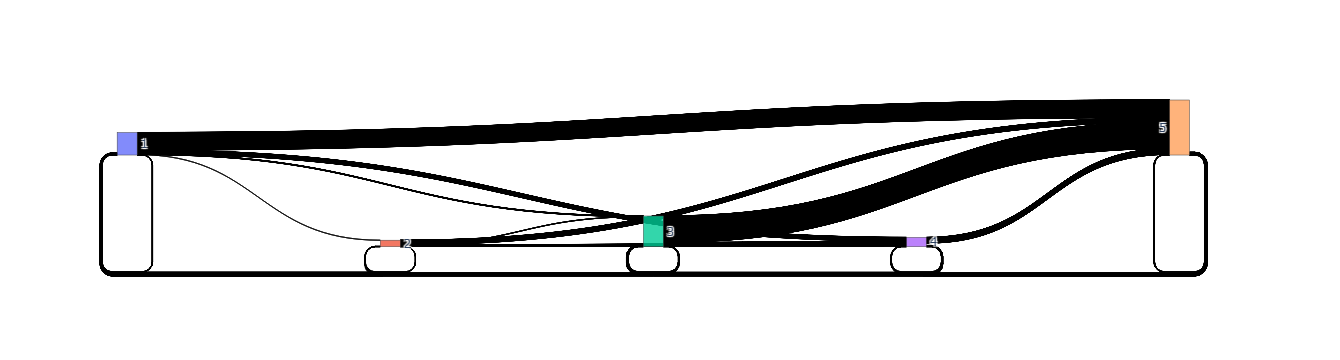

In [308]:
import plotly.graph_objects as go
merged_df = pd.merge(old_tariffs_df, new_tariffs_df, on='SUBSCRIBER_ID')

tariffs = list(set(merged_df['new_tariff'].unique()) | set(merged_df['old_tariff'].unique()))


tariff_indices = {tariff: i for i, tariff in enumerate(tariffs)}

sources = [tariff_indices[old_tariff] for old_tariff in merged_df['old_tariff']]
targets = [tariff_indices[new_tariff] for new_tariff in merged_df['new_tariff']]


values = [1] * len(sources)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=tariffs
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])


fig.show()

As we can see, the diagram is constructed. I have never built such a type of graph before, although from the perspective of flow, they are informative. At first glance, there was nothing surprising or incorrect for me here, as it's clearly visible that the majority of clients are flowing into 5 tariffs. However, as I later learned, there are cycles here, and that's not normal. Ideally, people shouldn't return to the same tariff. We will fix our diagram later, but for now, we can already see (as was mentioned) that many people are moving to the 5th tariff.








In [312]:
old_tariffs_df = df.query('END_DTTM != "$null$"')[['SUBSCRIBER_ID','TARIFF_PLAN_ID']]

In [313]:
old_tariffs_df

,SUBSCRIBER_ID,TARIFF_PLAN_ID
0,1,2
1,1,3
2,2,1
3,2,5
4,3,1
...,...,...
12339,5987,3
12340,5988,1
12341,5988,4
12342,5989,5


In [314]:
old_tariffs_df.rename(columns={'TARIFF_PLAN_ID':'old_tariff'},inplace = True)

In [315]:
old_tariffs_df.head()

,SUBSCRIBER_ID,old_tariff
0,1,2
1,1,3
2,2,1
3,2,5
4,3,1


In [316]:
new_tariffs_df = df.query('END_DTTM == "$null$"')[['SUBSCRIBER_ID','TARIFF_PLAN_ID']]

In [317]:
new_tariffs_df.rename(columns={'TARIFF_PLAN_ID':'new_tariff'},inplace = True)

In [318]:
merged_df.dtypes

old_tariff       int64
new_tariff       int64
SUBSCRIBER_ID    int64
dtype: object

Above in the code, those lines were simply duplicated to separate between old and new tariffs.

Here, to build a new diagram, let's convert our data to string type and add "1_" to them to differentiate the second one from the first, and then we'll construct a two-tier diagram.

In [319]:
merged_df[['new_tariff','old_tariff']] =  merged_df[['new_tariff','old_tariff']].astype('str')

In [320]:
merged_df.dtypes

old_tariff       object
new_tariff       object
SUBSCRIBER_ID     int64
dtype: object

In [321]:
 merged_df['new_tariff'] = '1_' + merged_df['new_tariff']

In [322]:
 merged_df['old_tariff'] = merged_df['old_tariff']

In [323]:
merged_df

,old_tariff,new_tariff,SUBSCRIBER_ID
0,2,1_3,1
1,1,1_5,2
2,1,1_5,3
3,3,1_5,4
4,1,1_5,5
...,...,...,...
6347,4,1_5,5985
6348,5,1_1,5986
6349,5,1_3,5987
6350,1,1_4,5988


In [324]:
merged_df = merged_df[['old_tariff','new_tariff', 'SUBSCRIBER_ID']]

In [325]:
merged_df

,old_tariff,new_tariff,SUBSCRIBER_ID
0,2,1_3,1
1,1,1_5,2
2,1,1_5,3
3,3,1_5,4
4,1,1_5,5
...,...,...,...
6347,4,1_5,5985
6348,5,1_1,5986
6349,5,1_3,5987
6350,1,1_4,5988


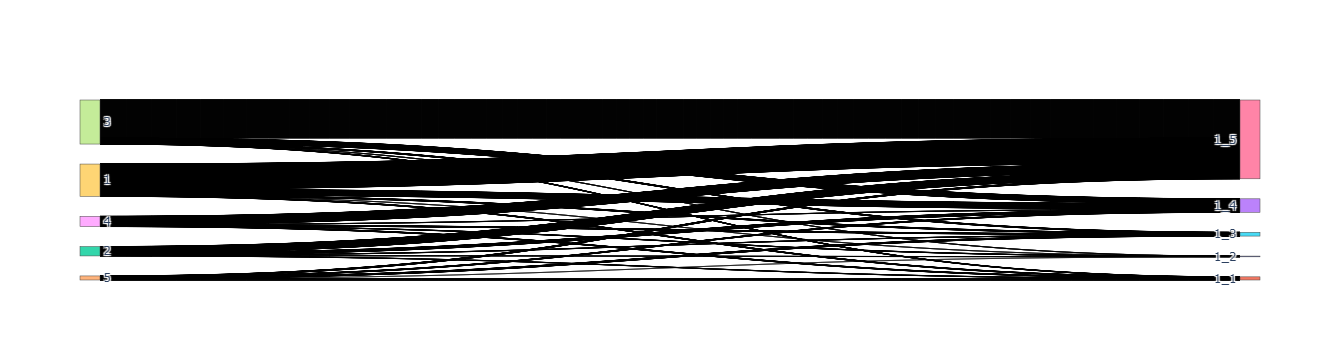

In [326]:
merged_df


tariffs = list(set(merged_df['new_tariff'].unique()) | set(merged_df['old_tariff'].unique()))


tariff_indices = {tariff: i for i, tariff in enumerate(tariffs)}


sources = [tariff_indices[old_tariff] for old_tariff in merged_df['old_tariff']]
targets = [tariff_indices[new_tariff] for new_tariff in merged_df['new_tariff']]


values = [1] * len(sources)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=tariffs
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.show()

We can see how much better this diagram is compared to the first one. Here, the flows are clearly visible, especially into tariff 4, but the majority is going to tariff 5.

In [40]:
merged_df

,old_tariff,new_tariff,SUBSCRIBER_ID
0,2,1_3,1
1,1,1_5,2
2,1,1_5,3
3,3,1_5,4
4,1,1_5,5
...,...,...,...
5652,4,1_5,5985
5653,5,1_1,5986
5654,5,1_3,5987
5655,1,1_4,5988


# CHECKS

Now let's proceed with our second task.








In [217]:
tariff_change = pd.read_csv('C:/Users/tuf/Desktop/Tariff_plans_change.csv')

In [223]:
charges = pd.read_csv('C:/Users/tuf/Desktop/Charges.csv')

In [224]:
charges.head()

,SUBSCRIBER_ID,BILL_MONTH,CHARGES
0,4741,2017-03-01,4.572
1,1754,2017-05-01,4.894
2,381,2017-01-01,6.670
3,5832,2016-12-01,4.299
4,5277,2017-03-01,1.610


The "charges" table is our new dataset containing the payment history of each subscriber for their tariff.

Our task is to compare the average monthly bill of subscribers over a period of 3 months after changing their tariff plan with the period of 3 months before changing the tariff plan. We need to identify which directions of tariff plan changes were characterized by an increase or decrease in the average bill over the three-month period and visualize the results on diagrams.

I checked how many times our users are duplicated.








In [225]:
charges.SUBSCRIBER_ID.value_counts()

SUBSCRIBER_ID
4741    19
2046    19
3714    19
3457    19
651     19
        ..
5982     9
5988     8
5987     8
5986     8
5989     8
Name: count, Length: 5989, dtype: int64

In [226]:
charges.dtypes

SUBSCRIBER_ID      int64
BILL_MONTH        object
CHARGES          float64
dtype: object

переведом строки в дату

In [227]:
charges['BILL_MONTH'] = pd.to_datetime(charges.BILL_MONTH,format = '%Y-%m-%d')

In [228]:
charges.BILL_MONTH.max()

Timestamp('2017-12-01 00:00:00')

In [229]:
charges.BILL_MONTH.min()

Timestamp('2016-06-01 00:00:00')

Let's look at the minimum and maximum dates.








In [230]:
charges.BILL_MONTH.max()  - charges.BILL_MONTH.min()

Timedelta('548 days 00:00:00')

There are no missing values.

In [231]:
charges.isna().mean()

SUBSCRIBER_ID    0.0
BILL_MONTH       0.0
CHARGES          0.0
dtype: float64

Let's make it so that when there is a null value in the dates, it ignores it and raises an error.

In [232]:
tariff_change['END_DTTM'] = pd.to_datetime(tariff_change.END_DTTM, format = '%Y-%m-%d %H:%M:%S',errors='coerce')

In [233]:
tariff_change['START_DTTM'] = pd.to_datetime(tariff_change.START_DTTM, format = '%Y-%m-%d %H:%M:%S')

In [234]:
tariff_change.START_DTTM.min()

Timestamp('1999-07-12 12:55:54')

In [235]:
tariff_change.END_DTTM.max()

Timestamp('2018-01-19 17:51:56')

Let's assign numbers to our tariffs, indicating which one is the first, second, or third in order for each subscriber.

In [236]:
tariff_change['tariff_number'] = tariff_change.groupby('SUBSCRIBER_ID')['START_DTTM'].rank(method='first')

In [237]:
tariff_change.groupby('START_DTTM').agg({'TARIFF_PLAN_ID':'count'}).sort_values('TARIFF_PLAN_ID',ascending=False)

,TARIFF_PLAN_ID
START_DTTM,
2006-10-30 13:57:17,3
2007-12-20 15:03:20,3
2017-02-21 19:33:34,2
2014-07-07 15:45:14,2
2017-05-26 19:18:36,2
...,...
2016-01-10 14:29:26,1
2016-01-12 18:14:08,1
2016-01-13 10:07:33,1


In [238]:
tariff_change.groupby('END_DTTM').agg({'TARIFF_PLAN_ID':'count'}).sort_values('TARIFF_PLAN_ID',ascending=False)

,TARIFF_PLAN_ID
END_DTTM,
2017-01-29 16:50:35,2
2017-06-04 11:40:01,2
2017-06-21 19:18:38,2
2017-01-20 13:23:56,2
2017-05-11 09:06:51,2
...,...
2017-02-28 22:27:13,1
2017-02-28 21:39:41,1
2017-02-28 21:39:31,1


To group them effectively, I separated the time from the date and created separate columns.

In [239]:
tariff_change['start_date_month'] = tariff_change.START_DTTM.dt.date.apply(lambda x : x.replace(day=1))

In [240]:
tariff_change['end_date_month'] = tariff_change.END_DTTM.dt.date.apply(lambda x : x.replace(day=1))

In [241]:
tariff_change

,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,tariff_number,start_date_month,end_date_month
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17,1.0,2013-11-01,2017-03-01
1,1,3,2017-03-11 14:24:18,NaT,2.0,2017-03-01,NaT
2,2,1,2016-02-05 16:36:34,2017-06-29 12:39:58,1.0,2016-02-01,2017-06-01
3,2,5,2017-06-29 12:39:59,NaT,2.0,2017-06-01,NaT
4,3,1,2015-05-06 19:17:46,2017-04-14 12:00:59,1.0,2015-05-01,2017-04-01
...,...,...,...,...,...,...,...
12339,5987,3,2017-05-23 13:07:57,NaT,2.0,2017-05-01,NaT
12340,5988,1,2017-05-10 10:36:53,2017-05-22 16:36:55,1.0,2017-05-01,2017-05-01
12341,5988,4,2017-05-22 16:36:56,NaT,2.0,2017-05-01,NaT
12342,5989,5,2017-05-24 14:46:11,2017-05-25 20:12:32,1.0,2017-05-01,2017-05-01


Let's create a graph where we can see that there was a surge in tariff changes in 2017, followed by a decline in 2018. I believe this might be due to the fact that they were given only one month of data.

datetime.date(2017, 6, 1)

<Axes: xlabel='start_date_month'>

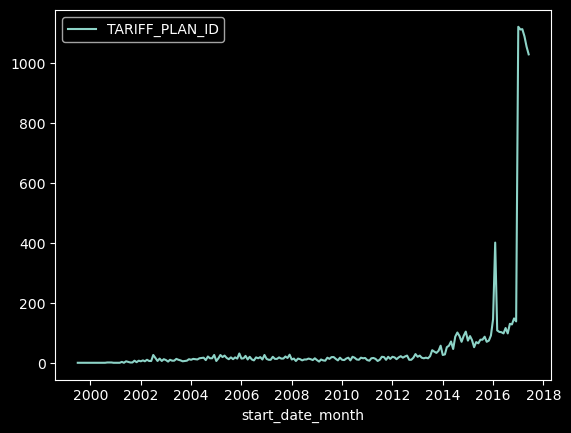

In [243]:
tariff_change.groupby('start_date_month').agg({'TARIFF_PLAN_ID':'count'}).sort_values('TARIFF_PLAN_ID',ascending=False).plot()

Also, to prevent pandas from skipping NaT values and to consider the value, we can assign a large date, assuming that it represents the tariff currently being used.

In [244]:
tariff_change['end_date_month_not_nan'] = tariff_change['end_date_month'].replace(np.nan,'9999-01-01')

As we can see, many people made multiple tariff changes in 2017, and many kept the tariff. It's difficult to say whether they kept the new tariff or reverted to the old one. From the graph above, we can make an assumption that many switched to a different tariff once and then kept it.








In [245]:
tariff_change.end_date_month_not_nan.value_counts()

end_date_month_not_nan
9999-01-01    5938
2017-02-01    1075
2017-03-01    1072
2017-04-01    1061
2017-01-01    1059
2017-05-01    1047
2017-06-01    1026
2018-01-01      66
Name: count, dtype: int64

Simply a heatmap of tariff transitions by year.








<Axes: xlabel='tariff_number', ylabel='START_DTTM'>

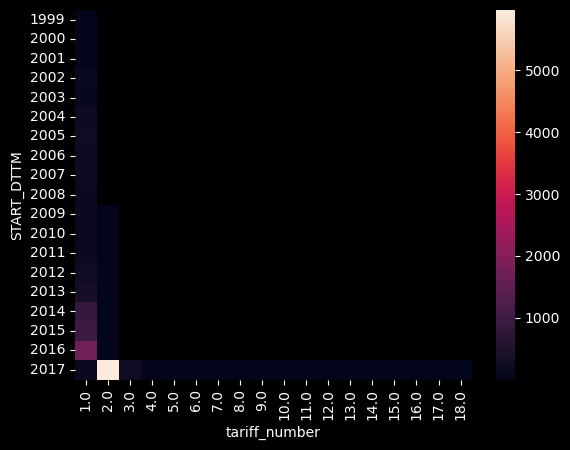

In [105]:
sns.heatmap(tariff_change.pivot_table(columns = 'tariff_number', index = tariff_change.START_DTTM.dt.year,values = 'SUBSCRIBER_ID', aggfunc ='count')) 

In [106]:
tariff_change.pivot_table(columns = 'tariff_number', index = tariff_change.START_DTTM.dt.year,values = 'SUBSCRIBER_ID', aggfunc ='count')

tariff_number,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
START_DTTM,,,,,,,,,,,,,,,,,,
1999,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Essentially, it's the same graph we built before, but it shows specifically how many people switched to a tariff for the second time.







<Axes: xlabel='start_date_month'>

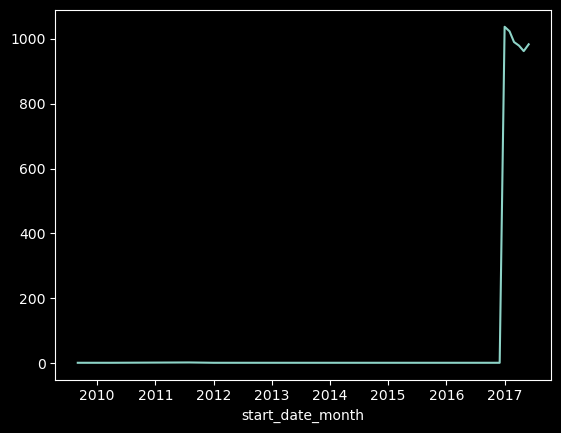

In [107]:
tariff_change[tariff_change['tariff_number'] == 2].groupby('start_date_month')['SUBSCRIBER_ID'].count().plot()

In [108]:
charges.SUBSCRIBER_ID.value_counts()

SUBSCRIBER_ID
4741    19
2046    19
3714    19
3457    19
651     19
        ..
5982     9
5988     8
5987     8
5986     8
5989     8
Name: count, Length: 5989, dtype: int64

In [109]:
charges.dtypes

SUBSCRIBER_ID             int64
BILL_MONTH       datetime64[ns]
CHARGES                 float64
year_bill                 int32
dtype: object

In [110]:
charges.BILL_MONTH.min()

Timestamp('2016-06-01 00:00:00')

In [111]:
charges.BILL_MONTH.max()

Timestamp('2017-12-01 00:00:00')

In [248]:
charges.head()

,SUBSCRIBER_ID,BILL_MONTH,CHARGES
0,4741,2017-03-01,4.572
1,1754,2017-05-01,4.894
2,381,2017-01-01,6.670
3,5832,2016-12-01,4.299
4,5277,2017-03-01,1.610


As we can see, there are minimum and maximum payments. There are individuals who seem to owe money, presumably one of the conditions for blocking, which I'll analyze later.








In [249]:
charges.CHARGES.min()

-528.576

In [250]:
charges.CHARGES.max()

639.858

In [251]:
charges['year_bill'] = charges.BILL_MONTH.dt.year

In [115]:
charges.groupby('year_bill').agg({'CHARGES':'count'})

,CHARGES
year_bill,
2016,40811
2017,71784


We also notice that in 2017, there were more transactions from people, not just in terms of the sum of payments. This could be because we have complete data for 2017, while for 2016, we only have data for half the year.

In [253]:
charges.BILL_MONTH.min()

Timestamp('2016-06-01 00:00:00')

In [254]:
charges.BILL_MONTH.max()

Timestamp('2017-12-01 00:00:00')

The total sum itself decreased in 2017, and we can see from the graph how it decreases.

<Axes: xlabel='BILL_MONTH'>

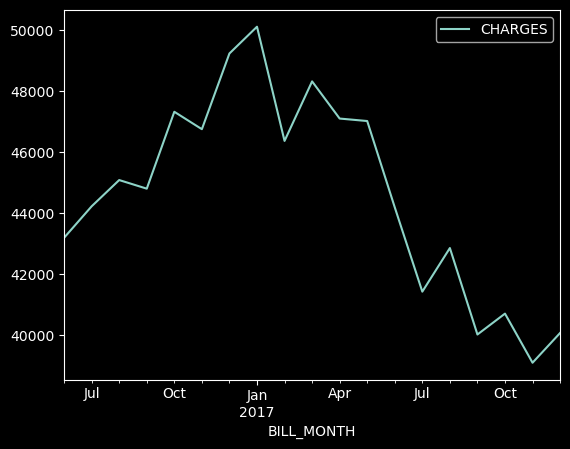

In [116]:
charges.groupby('BILL_MONTH').agg({'CHARGES':'sum'}).plot()

In [117]:
charges.SUBSCRIBER_ID.nunique()

5989

In [118]:
tariff_change.SUBSCRIBER_ID.nunique()

5989

Here begins my attempts to join tables to avoid duplications. One idea was to group everything else into a list and then join them by the ID that was grouped.

In [119]:
ch = charges.groupby('SUBSCRIBER_ID').agg({'CHARGES':sum,'BILL_MONTH': list})

In [120]:
ch.head()

,CHARGES,BILL_MONTH
SUBSCRIBER_ID,,
1,471.189,"[2016-12-01 00:00:00, 2017-10-01 00:00:00, 201..."
2,102.771,"[2017-11-01 00:00:00, 2017-04-01 00:00:00, 201..."
3,95.644,"[2017-01-01 00:00:00, 2017-11-01 00:00:00, 201..."
4,105.056,"[2017-12-01 00:00:00, 2017-03-01 00:00:00, 201..."
5,94.192,"[2016-10-01 00:00:00, 2017-01-01 00:00:00, 201..."


In [121]:
tc = tariff_change

In [263]:
tariff_change.head()

,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM,tariff_number,start_date_month,end_date_month,end_date_month_not_nan
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17,1.0,2013-11-01,2017-03-01,2017-03-01
1,1,3,2017-03-11 14:24:18,NaT,2.0,2017-03-01,NaT,9999-01-01
2,2,1,2016-02-05 16:36:34,2017-06-29 12:39:58,1.0,2016-02-01,2017-06-01,2017-06-01
3,2,5,2017-06-29 12:39:59,NaT,2.0,2017-06-01,NaT,9999-01-01
4,3,1,2015-05-06 19:17:46,2017-04-14 12:00:59,1.0,2015-05-01,2017-04-01,2017-04-01


In [264]:
df  =tc.merge(ch, on ='SUBSCRIBER_ID', how = 'left').reset_index()

Our task is to analyze how the average monthly bill of subscribers changed over a period of 3 months after changing the tariff plan compared to the period of 3 months before changing the tariff plan. We need to identify which directions of tariff plan changes were characterized by an increase or decrease in the average bill over the three-month period and visualize the results on diagrams.

Similarly, we need to analyze changes in the level of blockages: how often subscribers ended up in blocks after migration in general and for each migration direction separately. We'll compare the same periods: 3 months before the month of tariff plan change and 3 months after.

Let's proceed with analyzing and visualizing these results.

In [265]:
#df.groupby('SUBSCRIBER_ID').

In [266]:
month_charges = charges.groupby('BILL_MONTH')['CHARGES'].agg(['count','median','mean']).reset_index()

In [267]:
month_charges['BILL_MONTH'] = month_charges.BILL_MONTH.astype('str')

Here, we simply calculate the average payment.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, '2016-06-01'),
  Text(1, 0, '2016-07-01'),
  Text(2, 0, '2016-08-01'),
  Text(3, 0, '2016-09-01'),
  Text(4, 0, '2016-10-01'),
  Text(5, 0, '2016-11-01'),
  Text(6, 0, '2016-12-01'),
  Text(7, 0, '2017-01-01'),
  Text(8, 0, '2017-02-01'),
  Text(9, 0, '2017-03-01'),
  Text(10, 0, '2017-04-01'),
  Text(11, 0, '2017-05-01'),
  Text(12, 0, '2017-06-01'),
  Text(13, 0, '2017-07-01'),
  Text(14, 0, '2017-08-01'),
  Text(15, 0, '2017-09-01'),
  Text(16, 0, '2017-10-01'),
  Text(17, 0, '2017-11-01'),
  Text(18, 0, '2017-12-01')])

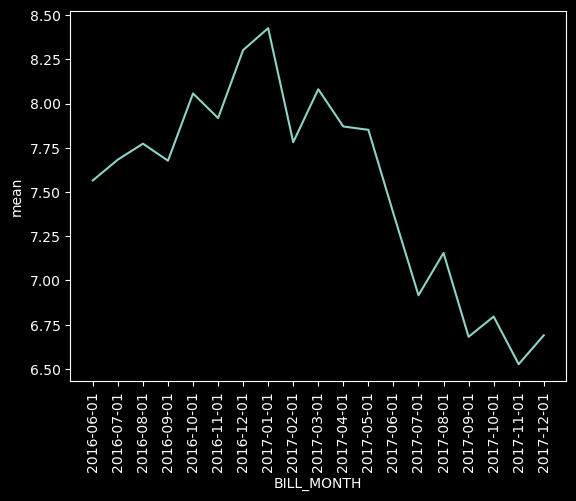

In [268]:
#month_charges[['BILL_MONTH','mean']].plot()
sns.lineplot(data =month_charges, x='BILL_MONTH',y='mean')
plt.xticks(rotation=90)

Essentially, the reason for this increase in the number of payments could be due to us having a full year of data for 2017 and only half a year for 2016.

<Axes: xlabel='BILL_MONTH'>

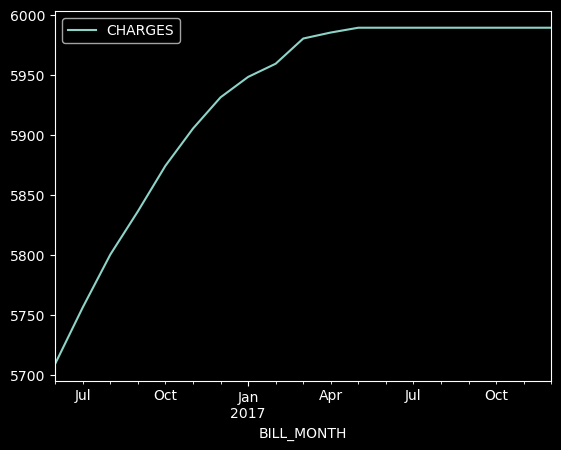

In [269]:
charges.groupby('BILL_MONTH').agg({'CHARGES':'count'}).plot()

As we can see, there isn't much difference in the number of transactions.

In [270]:
charges.groupby('BILL_MONTH').agg({'CHARGES':'count'})

,CHARGES
BILL_MONTH,
2016-06-01,5709
2016-07-01,5756
2016-08-01,5800
2016-09-01,5836
2016-10-01,5874
2016-11-01,5905
2016-12-01,5931
2017-01-01,5948
2017-02-01,5959


In [271]:
df.groupby('TARIFF_PLAN_ID').agg({'CHARGES':'sum'}).sort_values('CHARGES',ascending=False)

,CHARGES
TARIFF_PLAN_ID,
5,738639.892
3,451427.269
1,303234.315
4,173134.031
2,81263.322


In [288]:
df.groupby('TARIFF_PLAN_ID').agg({'CHARGES':'count'}).sort_values('CHARGES',ascending=False)

,CHARGES
TARIFF_PLAN_ID,
5,5050
3,2972
1,2189
4,1488
2,645


The total sum may not necessarily be higher for tariff 5 because the expenses are greater, but simply because there are more people on tariff 5, thus the total sum increases in comparison to other tariffs.

In [289]:
inf = df.groupby(['start_date_month','TARIFF_PLAN_ID'],as_index=False).agg({'CHARGES':'sum'}).sort_values('TARIFF_PLAN_ID',ascending=False)

In [290]:
inf.head()

,start_date_month,TARIFF_PLAN_ID,CHARGES
590,2017-06-01,5,154396.420
580,2017-04-01,5,128493.379
555,2016-11-01,5,1148.774
570,2017-02-01,5,102310.329
575,2017-03-01,5,110024.482


In [291]:
inf['count'] = df.groupby(['start_date_month','TARIFF_PLAN_ID'],as_index=False).agg({'CHARGES':'count'}).CHARGES

The number of subscribers monthly on each tariff.

In [292]:
inf.head()

,start_date_month,TARIFF_PLAN_ID,CHARGES,count
590,2017-06-01,5,154396.420,1007
580,2017-04-01,5,128493.379,872
555,2016-11-01,5,1148.774,8
570,2017-02-01,5,102310.329,726
575,2017-03-01,5,110024.482,773


It came to mind to calculate the conversion rate for each tariff.

In [294]:
inf['cr'] = inf['CHARGES'] / inf['count']  

In [295]:
inf.head()

,start_date_month,TARIFF_PLAN_ID,CHARGES,count,cr
590,2017-06-01,5,154396.420,1007,153.323158
580,2017-04-01,5,128493.379,872,147.354792
555,2016-11-01,5,1148.774,8,143.596750
570,2017-02-01,5,102310.329,726,140.923318
575,2017-03-01,5,110024.482,773,142.334388


Let's take the median to avoid strong outliers.

In [298]:
(139.116750+118.758000+147.302200)/3

135.05898333333334

In [299]:
(119.296611+142.965569)/2

131.13109

We calculated the average specifically for tariffs with the highest and lowest influx of customers. The conversion rate for tariffs with the highest influx of customers is slightly lower than for less popular tariffs. This could indicate that the price of popular tariffs is lower than that of unpopular ones.








In [297]:
inf.groupby('TARIFF_PLAN_ID').agg({'cr':'median'})

,cr
TARIFF_PLAN_ID,
1,139.116750
2,118.758000
3,147.302200
4,119.296611
5,142.965569


Here, I attempted to merge our tables and calculated the sum in both the old and new tables. They matched, meaning we avoided duplication by joining the tables. Additionally, I selected the maximum dates in the data where subscribers switched to another tariff. This will serve as the date after the switch so that we can assess how the expenses of users who switched to a new tariff changed over approximately 3 months.

In [300]:
diff = tariff_change.groupby('SUBSCRIBER_ID')['start_date_month'].max().reset_index()

In [301]:
diff = diff.merge(charges,how='inner')

In [302]:
charges.CHARGES.sum()

847874.2230000001

In [303]:
diff.CHARGES.sum()

847874.2230000001

In [140]:
diff.dtypes

SUBSCRIBER_ID                int64
start_date_month            object
BILL_MONTH          datetime64[ns]
CHARGES                    float64
year_bill                    int32
dtype: object

In [304]:
diff['start_date_month'] = pd.to_datetime(diff.start_date_month, format = '%Y-%m-%d')

In [305]:
diff.start_date_month - diff.BILL_MONTH

0          90 days
1        -214 days
2         -92 days
3         181 days
4        -184 days
            ...   
112590    -61 days
112591    -31 days
112592      0 days
112593   -214 days
112594   -153 days
Length: 112595, dtype: timedelta64[ns]

In [143]:
diff['diff'] = diff.start_date_month - diff.BILL_MONTH

In [144]:
before = diff.query('diff == "90 days"').groupby('SUBSCRIBER_ID').agg({'CHARGES':'sum'})

In [145]:
before['CHARGES'].sum()

15974.737

Over the last 90 days before the switch, there were 16,000.








In [146]:
after = diff.query('diff == "-90 days"').groupby('SUBSCRIBER_ID').agg({'CHARGES':'sum'})

In [147]:
after['CHARGES'].sum()

5871.530000000001

After the switch, it's almost 6. We can see that the total sum for new tariffs is much lower compared to the old ones. In my opinion, this is the main reason for the switch. We'll conclude the analysis here, and soon we'll move on to addressing the third question.

In [148]:
before = diff.query('diff == "90 days"').groupby('start_date_month').agg({'CHARGES':'sum'})

In [149]:
before

,CHARGES
start_date_month,
2017-03-01,7667.831
2017-04-01,8306.906


In [150]:
after = diff.query('diff == "-90 days"').groupby('start_date_month').agg({'CHARGES':'sum'})

In [151]:
after

,CHARGES
start_date_month,
2017-01-01,5871.53


In [152]:
diff.start_date_month.unique()

<DatetimeArray>
['2017-03-01 00:00:00', '2017-06-01 00:00:00', '2017-04-01 00:00:00',
 '2017-01-01 00:00:00', '2017-05-01 00:00:00', '2017-02-01 00:00:00']
Length: 6, dtype: datetime64[ns]